In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import nltk
from sklearn.metrics import roc_auc_score
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [3]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Define the preprocessing functions
def remove_special_chars(text):
    # Remove special characters and punctuation
    clean_text = re.sub(r'[^\w\s]', '', text)
    return clean_text

def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    return lemmatized_tokens

In [5]:
df = pd.read_csv(r'C:\Users\ki_shari\Downloads\DFF.csv', encoding='latin-1')

In [6]:
df.head(5)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,ORIGINAL_TEXT,normalized_scores,incon
0,1,1,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",0.726538,Medium
1,2,1,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.723638,Medium
2,3,1,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0.483963,Low
3,4,1,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,0.726538,Medium
4,5,1,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.726538,Medium


In [7]:
print(df['ORIGINAL_TEXT'])

0        When least you think so, this product will sav...
1        Lithium batteries are something new introduced...
2        I purchased this swing for my baby. She is 6 m...
3        I was looking for an inexpensive desk calcolat...
4        I only use it twice a week and the results are...
                               ...                        
20995    I bought these for work.  I have high arches, ...
20996    Crocs are one of only two brands of shoes that...
20997    I love moccasins  This fit like it was custom ...
20998    I wish these were a little more durable. I got...
20999    I've been looking for a replacement for my bel...
Name: ORIGINAL_TEXT, Length: 21000, dtype: object


In [8]:
df.loc[df["LABEL"] == "__label1__", "LABEL"] = 1
df.loc[df["LABEL"] == "__label2__", "LABEL"] = 0
df['LABEL']=pd.to_numeric(df['LABEL'])

In [9]:
# Apply the preprocessing steps
df['ORIGINAL_TEXT'] = df['ORIGINAL_TEXT'].apply(remove_special_chars)
df['ORIGINAL_TEXT'] = df['ORIGINAL_TEXT'].apply(preprocess_text)

<Axes: >

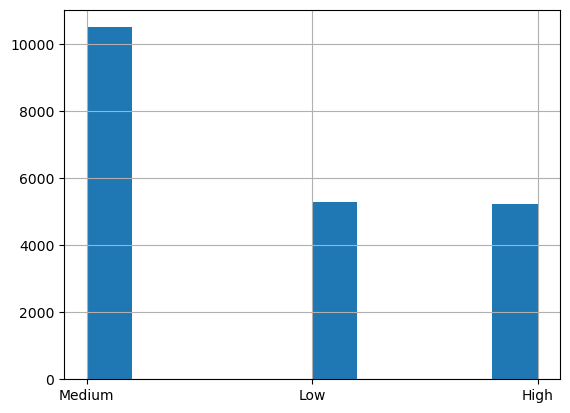

In [10]:
df['incon'].hist()

In [11]:
print(df['incon'])

0        Medium
1        Medium
2           Low
3        Medium
4        Medium
          ...  
20995    Medium
20996    Medium
20997      High
20998    Medium
20999    Medium
Name: incon, Length: 21000, dtype: object


In [12]:
# Convert the 'incon' column to numerical values
incon_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['incon_encoded'] = df['incon'].map(incon_mapping)

# Prepare the target labels
labels = np.array(df['LABEL'].tolist())

In [13]:
print(df['ORIGINAL_TEXT'])

0        [least, think, product, save, day, keep, aroun...
1        [lithium, batteri, someth, new, introduc, mark...
2        [purchas, swing, babi, 6, month, pretti, much,...
3        [look, inexpens, desk, calcolatur, work, every...
4        [use, twice, week, result, great, use, teeth, ...
                               ...                        
20995    [bought, work, high, arch, use, arch, support,...
20996    [croc, one, two, brand, shoe, foot, day, work,...
20997    [love, moccasin, fit, like, custom, made, mebr...
20998    [wish, littl, durabl, got, caught, bolt, cross...
20999    [ive, look, replac, belov, kso, trek, own, two...
Name: ORIGINAL_TEXT, Length: 21000, dtype: object


In [14]:
# Split into features and target
X = df['ORIGINAL_TEXT'].values
y = df['LABEL'].values
incon_encoded = df['incon_encoded'].values
normalized_scores = df['normalized_scores'].values


# Convert labels to binary format (0, 1)
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
# Define the parameters for tokenization and padding
max_features = 10000  # Maximum number of words to keep based on word frequency
maxlen = 100  # Maximum length of each review (truncate or pad with zeros)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)

# Pad the sequences
X_padded = pad_sequences(X_tokenized, maxlen=maxlen)

# Load GloVe embeddings
embedding_dim = 300
embedding_path = 'C:\\Users\\ki_shari\\Downloads\\glove.6B.300d.txt\\glove.6B.300d.txt'

embedding_matrix = np.zeros((max_features, embedding_dim))
with open(embedding_path, encoding='utf-8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        if word in tokenizer.word_index and tokenizer.word_index[word] < max_features:
            embedding_matrix[tokenizer.word_index[word]] = np.fromstring(vec, sep=' ')

In [29]:
# Define the model architecture
input1 = Input(shape=(maxlen,))
input2 = Input(shape=(1,))  # Input for incon

embedding_layer = Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)(input1)
gru_layer = Bidirectional(GRU(64))(embedding_layer)

concat_layer = Concatenate()([gru_layer, input2])
output = Dense(1, activation='sigmoid')(concat_layer)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['incon_encoded'][train_index], df['incon_encoded'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = np.round(y_pred).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 21s 160ms/step
Accuracy: 0.8613809523809524
F1 Score: 0.8588240551063532
Recall: 0.8536190476190477
Precision: 0.8646525287050576
AUC: 0.9092801133786848


In [ ]:
#####CNN+BiGRU

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    gru_layer = Bidirectional(GRU(64))(embedding_layer)
    concatenated = Concatenate()([gru_layer, concatenated])

    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['incon_encoded'][train_index], df['incon_encoded'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Create the hybrid model
    model = create_hybrid_model(max_features, embedding_dim, maxlen)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 31s 204ms/step
Accuracy: 0.6232380952380951
F1 Score: 0.6181938590279368
Recall: 0.6105714285714287
Precision: 0.626752614962507
AUC: 0.6685561451247166


In [ ]:
####CNN+BiLSTM

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    lstm_layer = Bidirectional(LSTM(64))(embedding_layer)
    concatenated = Concatenate()([lstm_layer, concatenated])

    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['incon_encoded'][train_index], df['incon_encoded'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Create the hybrid model
    model = create_hybrid_model(max_features, embedding_dim, maxlen)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 93s 693ms/step
Accuracy: 0.6228571428571429
F1 Score: 0.6237693407010736
Recall: 0.6260000000000001
Precision: 0.6225446198007234
AUC: 0.6730128344671202


In [ ]:
####normalized_incon

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Define the model architecture
input1 = Input(shape=(maxlen,))
input2 = Input(shape=(1,))  # Input for incon

embedding_layer = Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)(input1)
gru_layer = Bidirectional(GRU(128, dropout=0.2))(embedding_layer)

concat_layer = Concatenate()([gru_layer, input2])
output = Dense(1, activation='sigmoid')(concat_layer)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = np.round(y_pred).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 7s 53ms/step
Accuracy: 0.9021904761904762
F1 Score: 0.9007358495925267
Recall: 0.9035238095238096
Precision: 0.8983013182897231
AUC: 0.9258091156462586


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    gru_layer = Bidirectional(GRU(64))(embedding_layer)
    concatenated = Concatenate()([gru_layer, concatenated])

    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Create the hybrid model
    model = create_hybrid_model(max_features, embedding_dim, maxlen)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 47s 351ms/step
Accuracy: 0.6192857142857143
F1 Score: 0.612259095142868
Recall: 0.602
Precision: 0.6240971371709229
AUC: 0.6656344897959185


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    lstm_layer = Bidirectional(LSTM(64))(embedding_layer)
    concatenated = Concatenate()([lstm_layer, concatenated])

    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Create the hybrid model
    model = create_hybrid_model(max_features, embedding_dim, maxlen)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
    model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
              batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))
print("AUC:", np.mean(auc_scores))

132/132 [==============================] - 85s 640ms/step
Accuracy: 0.6214285714285714
F1 Score: 0.6250121142901157
Recall: 0.6317142857142858
Precision: 0.6188893415297946
AUC: 0.6719804535147393


In [ ]:
##BiGRU/grid search

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, GRU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

def create_model(dropout_rate=0.5, gru_units=64):
    input1 = Input(shape=(maxlen,))
    input2 = Input(shape=(1,))  # Input for incon

    embedding_layer = Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)(input1)
    gru_layer = Bidirectional(GRU(gru_units))(embedding_layer)

    concat_layer = Concatenate()([gru_layer, input2])
    dropout_layer = Dropout(dropout_rate)(concat_layer)
    output = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with scikit-learn interface
keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'batch_size': [16, 32],
    'reduce_lr__patience': [3, 5],
    'reduce_lr__factor': [0.5, 0.1],
    'dropout_rate': [0.2, 0.5],
    'gru_units': [32, 64]
}

# Perform grid search with cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=kf, scoring='accuracy')
grid_result = grid_search.fit([X_padded, df['normalized_scores']], df['LABEL'])

# Print the best parameters and results
print("Best parameters:", grid_result.best_params_)
print("Best accuracy:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Retrieve the best model
best_model = grid_result.best_estimator_.model

# Perform evaluation using the best model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def create_input_data(X, normalized_scores):
    return [X, normalized_scores]

accuracy_scores = []
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for train_index, test_index in kf.split(X_padded, df['LABEL']):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
    y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=grid_result.best_params_['reduce_lr__patience'],
                                 factor=grid_result.best_params_['reduce_lr__factor'], min_lr=0.0001)
    best_model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
                   batch_size=grid_result.best_params_['batch_size'], epochs=10,
                   callbacks=[reduce_lr], verbose=0)

    # Evaluate the model
    y_pred = best_model.predict([X_test, incon_test])
    y_pred_binary = np.round(y_pred).flatten()
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    auc_scores.append(roc_auc_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))

# Print evaluation metrics
print("Accuracy:", np.mean(accuracy_scores))
print("AUC:", np.mean(auc_scores))
print("F1 Score:", np.mean(f1_scores))
print("Recall:", np.mean(recall_scores))
print("Precision:", np.mean(precision_scores))

C:\Users\ki_shari\AppData\Local\Temp\ipykernel_16744\833383917.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)


ValueError: Found input variables with inconsistent numbers of samples: [2, 21000]

In [60]:
print(len(X_padded))
print(len(df['normalized_scores']))

21000
21000


In [ ]:
###CNN+BiGRU/grid search

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from itertools import product

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen, filters, kernel_size, gru_units, dense_units, dropout_rate):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(filters, kernel_size, activation='relu')(embedding_layer)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(filters, kernel_size+1, activation='relu')(embedding_layer)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv1D(filters, kernel_size+2, activation='relu')(embedding_layer)
    conv3 = BatchNormalization()(conv3)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    gru_layer = Bidirectional(GRU(gru_units))(embedding_layer)
    concatenated = Concatenate()([gru_layer, concatenated])

    dense1 = Dense(dense_units, activation='relu')(concatenated)
    dense1 = BatchNormalization()(dense1)
    dropout1 = Dropout(dropout_rate)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform grid search to find the best hyperparameters
max_features = max_features
embedding_dim = 300
maxlen = 100
X_padded = pad_sequences(X_tokenized, maxlen=maxlen)

param_grid = {
    'filters': [64, 128],
    'kernel_size': [3, 4, 5],
    'gru_units': [32, 64],
    'dense_units': [32, 64],
    'dropout_rate': [0.2, 0.5]
}

best_accuracy = 0.0
best_params = {}

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for params in product(*param_grid.values()):
    filters, kernel_size, gru_units, dense_units, dropout_rate = params
    accuracy_scores = []
    f1_scores = []
    recall_scores = []
    precision_scores = []
    auc_scores = []

    for train_index, test_index in kf.split(X_padded, df['LABEL']):
        X_train, X_test = X_padded[train_index], X_padded[test_index]
        incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
        y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

        # Create the hybrid model
        model = create_hybrid_model(max_features, embedding_dim, maxlen, filters, kernel_size, gru_units, dense_units, dropout_rate)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
        model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
                  batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

        # Evaluate the model
        y_pred = model.predict([X_test, incon_test])
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()
        accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
        f1_scores.append(f1_score(y_test, y_pred_binary))
        recall_scores.append(recall_score(y_test, y_pred_binary))
        precision_scores.append(precision_score(y_test, y_pred_binary))
        auc_scores.append(roc_auc_score(y_test, y_pred))

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_auc = np.mean(auc_scores)

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params

    print("Params:", params)
    print("Accuracy:", avg_accuracy)
    print("F1 Score:", avg_f1)
    print("Recall:", avg_recall)
    print("Precision:", avg_precision)
    print("AUC:", avg_auc)
    print()

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Retrain the model with the best hyperparameters on the full training dataset
best_filters, best_kernel_size, best_gru_units, best_dense_units, best_dropout_rate = best_params
X_train, incon_train, y_train = ...
model = create_hybrid_model(max_features, embedding_dim, maxlen, best_filters, best_kernel_size, best_gru_units, best_dense_units, best_dropout_rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=1)

# Evaluate the model on the test set
X_test, incon_test, y_test = ...
y_pred = model.predict([X_test, incon_test])
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)

132/132 [==============================] - 74s 555ms/step
Params: (64, 3, 32, 32, 0.2)
Accuracy: 0.6268571428571429
F1 Score: 0.6365573139462102
Recall: 0.6545714285714286
Precision: 0.6214707233603642
AUC: 0.6799805215419501

132/132 [==============================] - 62s 458ms/step
Params: (64, 3, 32, 32, 0.5)
Accuracy: 0.6243809523809525
F1 Score: 0.6295060249148061
Recall: 0.6412380952380954
Precision: 0.6218784804607078
AUC: 0.6735063945578232

132/132 [==============================] - 43s 317ms/step
Params: (64, 3, 32, 64, 0.2)
Accuracy: 0.6251428571428571
F1 Score: 0.6384754780758971
Recall: 0.6646666666666666
Precision: 0.6179969922232157
AUC: 0.6820429251700679

132/132 [==============================] - 52s 391ms/step
Params: (64, 3, 32, 64, 0.5)
Accuracy: 0.6258571428571429
F1 Score: 0.6241437063628522
Recall: 0.6221904761904762
Precision: 0.627511819183292
AUC: 0.6768851247165533

132/132 [==============================] - 99s 740ms/step
Params: (64, 3, 64, 32, 0.2)
Accura

KeyboardInterrupt: 

In [ ]:
###CNN+BiLSTM/grid search

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from itertools import product

# Define the model architecture
def create_hybrid_model(vocab_size, embedding_dim, maxlen, filters, kernel_size, gru_units, dense_units, dropout_rate):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))

    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(filters, kernel_size, activation='relu')(embedding_layer)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(filters, kernel_size+1, activation='relu')(embedding_layer)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv1D(filters, kernel_size+2, activation='relu')(embedding_layer)
    conv3 = BatchNormalization()(conv3)

    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)

    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])

    lst_layer = Bidirectional(LSTM(gru_units))(embedding_layer)
    concatenated = Concatenate()([lst_layer, concatenated])

    dense1 = Dense(dense_units, activation='relu')(concatenated)
    dense1 = BatchNormalization()(dense1)
    dropout1 = Dropout(dropout_rate)(dense1)

    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

# Perform grid search to find the best hyperparameters
max_features = max_features
embedding_dim = 300
maxlen = 100
X_padded = pad_sequences(X_tokenized, maxlen=maxlen)

param_grid = {
    'filters': [64, 128],
    'kernel_size': [3, 4, 5],
    'gru_units': [32, 64],
    'dense_units': [32, 64],
    'dropout_rate': [0.2, 0.5]
}

best_accuracy = 0.0
best_params = {}

# Perform 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for params in product(*param_grid.values()):
    filters, kernel_size, lst_units, dense_units, dropout_rate = params
    accuracy_scores = []
    f1_scores = []
    recall_scores = []
    precision_scores = []
    auc_scores = []

    for train_index, test_index in kf.split(X_padded, df['LABEL']):
        X_train, X_test = X_padded[train_index], X_padded[test_index]
        incon_train, incon_test = df['normalized_scores'][train_index], df['normalized_scores'][test_index]
        y_train, y_test = df['LABEL'][train_index], df['LABEL'][test_index]

        # Create the hybrid model
        model = create_hybrid_model(max_features, embedding_dim, maxlen, filters, kernel_size, gru_units, dense_units, dropout_rate)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)
        model.fit([X_train, incon_train], y_train, validation_data=([X_test, incon_test], y_test),
                  batch_size=16, epochs=10, callbacks=[reduce_lr], verbose=0)

        # Evaluate the model
        y_pred = model.predict([X_test, incon_test])
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()
        accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
        f1_scores.append(f1_score(y_test, y_pred_binary))
        recall_scores.append(recall_score(y_test, y_pred_binary))
        precision_scores.append(precision_score(y_test, y_pred_binary))
        auc_scores.append(roc_auc_score(y_test, y_pred))

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_auc = np.mean(auc_scores)

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params

    print("Params:", params)
    print("Accuracy:", avg_accuracy)
    print("F1 Score:", avg_f1)
    print("Recall:", avg_recall)
    print("Precision:", avg_precision)
    print("AUC:", avg_auc)
    print()

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Retrain the model with the best hyperparameters on the full training dataset
best_filters, best_kernel_size, best_lst_units, best_dense_units, best_dropout_rate = best_params
#X_train, incon_train, y_train = ...
model = create_hybrid_model(max_features, embedding_dim, maxlen, best_filters, best_kernel_size, best_lst_units, best_dense_units, best_dropout_rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=1)

# Evaluate the model on the test set
#X_test, incon_test, y_test = ...
y_pred = model.predict([X_test, incon_test])
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)